In [1]:
%pylab inline
#-----Loading packages--------------
import pyfftw
from scipy.special import laguerre
from scipy.special import hermite
import numpy as np
import scipy.fftpack as fftpack
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py

Populating the interactive namespace from numpy and matplotlib


### 1. Defining Propagators factors bridge with C

In [42]:
%load_ext cythonmagic

The cythonmagic extension is already loaded. To reload it, use:
  %reload_ext cythonmagic


In [43]:
%%cython

import numpy as np
cimport numpy as np
cimport cython
from cython cimport parallel

cdef extern from "complex.h":
    double complex csqrt(double complex z) nogil
    double complex cexp(double complex z) nogil
    double creal(double complex z) nogil
    double cimag(double complex z) nogil

from libc.math cimport pow

@cython.boundscheck(False)
@cython.wraparound(False)
def ExpPotential_XTheta_Parallel( np.ndarray[ double complex ,ndim=2,mode='c'] W,int X1_DIM,int P1_DIM,double dx1,double dTheta1, double dt ):
    cdef int threadIdx_x
    cdef int blockIdx_x
    cdef int j1, i1
    cdef double x1, theta1
    cdef double arg    
    cdef int hbar
    
    hbar = 1
    
    with nogil, cython.boundscheck(False), cython.wraparound(False):
        for threadIdx_x in parallel.prange( X1_DIM , schedule='static', num_threads=6 ):
            for blockIdx_x in  range(P1_DIM):

                j1 =  (threadIdx_x + X1_DIM/2) % X1_DIM 
                i1 =  (blockIdx_x  + P1_DIM/2) % P1_DIM 

                x1         =  (j1 - 0.5*X1_DIM  )*dx1
                theta1     =  (i1 - 0.5*P1_DIM  )*dTheta1

                arg = -dt*( 0.5*pow(x1 - 0.5*hbar*theta1,2) - 0.5*pow(x1 + 0.5*hbar*theta1,2) )

                W[  threadIdx_x  , blockIdx_x  ]  *= cexp(1j*arg)  
                
#-----------------------------------------------------------------------------------------

def ExpKinetic_PLambda_Parallel( np.ndarray[ double complex ,ndim=2,mode='c'] W,int X1_DIM,int P1_DIM,double dp1,double dLambda1, double dt ):
    cdef int threadIdx_x
    cdef int blockIdx_x
    cdef int j1, i1
    cdef double p1, Lambda1
    cdef double arg    
    #cdef int hbar
    
    #hbar = 1
    
    with nogil, cython.boundscheck(False), cython.wraparound(False):
        for threadIdx_x in parallel.prange( X1_DIM , schedule='static', num_threads=6 ):
            for blockIdx_x in  range(P1_DIM):

                j1 =  (threadIdx_x + X1_DIM/2) % X1_DIM 
                i1 =  (blockIdx_x  + P1_DIM/2) % P1_DIM 

                p1          =  (j1 - 0.5*P1_DIM  )*dp1
                Lambda1     =  (i1 - 0.5*X1_DIM  )*dLambda1

                arg = -dt*p1*Lambda1

                W[  threadIdx_x  , blockIdx_x  ]  *= cexp(1j*arg)  
  

### 2. Harmonic  Potential

In [44]:
mass = 1.
omega = 1.

def Potential(x):
        return 0.5*mass*omega**2*x**2
    
#----Gradient of quartic potencial

def dPotentialdx(x):  
    return mass*omega**2*x

### 3. Parameters in atomic units

In [45]:
X_gridDIM =  512     # Discretization grid size in X
P_gridDIM =  512     # Discretization grid size in P
        
X_amplitude  = 10    # Window range -X_amplitude to X_amplitude
P_amplitude  = 10    # Window range -P_amplitude to P_amplitude
        
dt= 0.005             # Time discretization
timeSteps =    100  # Number of iterations
hbar = 1    

        
print ' Simulation time = ', timeSteps*dt ,'(a.u.)'

 Simulation time =  0.5 (a.u.)


### 4.Resolution & coordinates

In [46]:
# Discretization resolution

dX =  2.*X_amplitude/float(X_gridDIM)
dP =  2.*P_amplitude/float(P_gridDIM)

dTheta  = 2.*np.pi/(2.*P_amplitude)
Theta_amplitude = dTheta*P_gridDIM/2.
dLambda = 2.*np.pi/(2.*X_amplitude)
Lambda_amplitude = dLambda*X_gridDIM/2.

# vectors with range of coordinates

timeRange     =  np.array(range(0,timeSteps+1))*dt 

X_range      =  np.linspace(-X_amplitude      , X_amplitude  -dX , X_gridDIM )
Lambda_range =  np.linspace(-Lambda_amplitude , Lambda_amplitude-dLambda  , X_gridDIM)

Theta_range  = np.linspace(-Theta_amplitude  , Theta_amplitude - dTheta , P_gridDIM)
P_range      = np.linspace(-P_amplitude      , P_amplitude-dP           , P_gridDIM)	

# matrices of grid of coordinates
X      = fftpack.fftshift(X_range)[np.newaxis,:]
Theta  = fftpack.fftshift(Theta_range)[:,np.newaxis]

Lambda = fftpack.fftshift(Lambda_range)[np.newaxis,:]
P      = fftpack.fftshift(P_range)[:,np.newaxis]

print "Resolution features : "
print ""
print "dX =", dX ,"                            dP = ",dP
print ""
print "X_amplitude =",X_amplitude, "                            P_amplitude =",P_amplitude
print ""
print "dLambda =" ,dLambda ,"                   dTheta =",dTheta
print ""
print "+-Lambda_amplitude =",Lambda_amplitude,"         +-Theta_amplitude =",Theta_amplitude

Resolution features : 

dX = 0.0390625                             dP =  0.0390625

X_amplitude = 10                             P_amplitude = 10

dLambda = 0.314159265359                    dTheta = 0.314159265359

+-Lambda_amplitude = 80.4247719319          +-Theta_amplitude = 80.4247719319


# 5.USEFULL FUNCTIONS

### 5.1 Theoricals wigner functions

In [47]:
def  Wigner_HarmonicOscillator(n,mass,omega,x,p):
    """
    Wigner function of the Harmonic oscillator
            Parameters
            x,p  : center of wave packet
            n    : Quantum number  
    """
    r2 = mass*omega**2*((X - x))**2 + ((P - p ))**2/mass 
    return  (-1)**(n)*laguerre(n)( 2*r2  )*np.exp(-r2 )


In [48]:
def Wigner_gaussian(x,p):
    """
    Wigner function of a Gaussian
    x,p  : center of wave packet
    """
    return np.exp( -(X-x)**2 -(P-p)**2 ) + 0j

### 3.2 Theorical coherent states

In [49]:
def W_Theorical_Coherent(x_shift):
    
    """This fuction computes coherents states from theorical ground state"""
    
    return Wigner_HarmonicOscillator(0,mass,omega,x_shift,0)

### 5.3 Wigner propagator

In [50]:
def WignerPropagator(W0):
    
    #------------------------ Performing    FFTW----------------------------------------
    
    FFTW_attemp = 'FFTW_PATIENT'    # fftw takes more time initialializing the first time
    #FFTW_attemp = 'FFTW_MEASURE'   # this flag initializes fftw faster

    import pickle

    try :
        with open("fftw_wisdom", "rb") as fw : pyfftw.import_wisdom(pickle.load(fw))
    
    except IOError : pass
    
    
        
    W = W0.copy() 
    
    fft_object_PX_to_PLambda   = pyfftw.FFTW(W,W, axes=(1,), threads=6, flags=(FFTW_attemp,) )
    ifft_object_PLambda_to_PX  = pyfftw.FFTW(W,W, axes=(1,),  direction='FFTW_BACKWARD', threads=6, flags=(FFTW_attemp,) )    
    fft_object_PX_to_ThetaX = pyfftw.FFTW(W,W, axes=(0,), threads=6, flags=(FFTW_attemp,) )
    ifft_object_ThetaX_to_PX = pyfftw.FFTW(W,W, axes=(0,),  direction='FFTW_BACKWARD', threads=6, flags=(FFTW_attemp,) ) 
    
    with open("fftw_wisdom", "wb") as fw : pickle.dump (pyfftw.export_wisdom(), fw)
    
    #------List to save data for Ehrenfest Theorems ,Energy and Uncertainty principle ------------
    
    data_Expec_X  = [np.sum(X*W0)*dP*dX]
    data_Expec_X2 = [np.sum(X**2*W0)*dP*dX]
    data_Expec_P  = [np.sum(P*W0)*dP*dX]
    data_Expec_P2 = [np.sum(P**2*W0)*dP*dX]
    data_Expec_XP = [np.sum(X*P*W0)*dP*dX]
    data_Expec_F  = [-1*np.sum( dPotentialdx(X)*W0)*dP*dX]
    data_Expec_XdVdX = [np.sum(X*dPotentialdx(X)*W0)*dP*dX]
    data_Expec_V = [np.sum(Potential(X)*W0)*dP*dX]
    data_NegArea = [np.sum(W0[np.nonzero( W0.real < 0. )]).real*dP*dX]
    data_Pur = [np.sum(W0.real**2)*dX*dP] # purity
    
    #---------------------------- Moyal propagator-------------------------------------------------
   
    initial_time = time.time()
    
    for tIndex in range(1,timeSteps+1):
        if tIndex%5000==0:
            print '  tIndex  = ', tIndex
            
        t = (tIndex)*dt
        # p x  ->  p lambda 
         
        W[:] = fft_object_PX_to_PLambda()
        #W[:] *=expPLambda
        ExpKinetic_PLambda_Parallel( W,X_gridDIM,P_gridDIM,dP,dLambda, dt )

        # p lambda  ->  p x
        
        W[:] = ifft_object_PLambda_to_PX()
        
        # p x -> theta x      
        
        W[:] = fft_object_PX_to_ThetaX()
       
        #W[:] *= expPotential
        ExpPotential_XTheta_Parallel(W, X_gridDIM, P_gridDIM, dX, dTheta, dt )    
        
        # theta x  ->  p x
        
        W[:] = ifft_object_ThetaX_to_PX() 
        
        # Normalization
        #norm = np.sum( W )*dX*dP
        
        #W[:] /= norm
        
        #--- Compute expectations values
        
        Expec_X  = np.sum(X*W)*dP*dX
        Expec_X2 = np.sum(X**2*W)*dP*dX
        Expec_P  = np.sum(P*W)*dP*dX
        Expec_P2 = np.sum(P**2*W)*dP*dX
        Expec_XP = np.sum(X*P*W)*dP*dX
        Expec_F  = -1*np.sum( dPotentialdx(X)*W)*dP*dX 
        Expec_XdVdX = np.sum(X*dPotentialdx(X)*W)*dP*dX
        Expec_V = np.sum(Potential(X)*W)*dP*dX
        
        #----Negative area
        
        NegArea = np.sum(W[np.nonzero( W.real < 0. )]).real*dP*dX
        
        #---- Purity of the state
        
        Pur = np.sum(W.real**2)*dX*dP
        
        #--- Make data list
        
        data_Expec_X.append(Expec_X)  # 1
        data_Expec_X2.append(Expec_X2) #2
        data_Expec_P.append(Expec_P)   #3
        data_Expec_P2.append(Expec_P2) #4
        data_Expec_XP.append(Expec_XP) #5
        data_Expec_F.append(Expec_F)   #6
        data_Expec_XdVdX.append(Expec_XdVdX) #7
        data_Expec_V.append(Expec_V) #8
        data_NegArea.append(NegArea) #9
        data_Pur.append(Pur) #10
    
    
    final_time = time.time()

    print 'Computation time to compute propagation = ', final_time - initial_time, ' seconds'
         
        
    return W.real ,data_Expec_X,data_Expec_X2,data_Expec_P,data_Expec_P2,data_Expec_XP,data_Expec_F,data_Expec_XdVdX,data_Expec_V,data_NegArea,data_Pur  



### 5.4 Plot Wigner  function

In [51]:
# Matrix of classical Hamiltonial

Hamiltonian_Classical = fftpack.fftshift( P**2/(2*mass) + Potential(X) )

In [52]:
def PlotWigner(W):
    
    print "max imaginary = ",np.max(np.imag(W))
    
    W = np.real(W)
    
    W = fftpack.fftshift( W )
    
    global_color_max = 0.17          #  Maximum value used to select the color range
    global_color_min = -0.31         # 
        
    print 'min real = ', np.min( W ), ' max real = ', np.max( W )
    
    print 'normalization = ', np.sum( W )*dX*dP
    zero_position =  abs( global_color_min) / (abs( global_color_max) + abs(global_color_min)) 
    wigner_cdict = {'red' 	: 	((0., 0., 0.),
							(zero_position, 1., 1.), 
							(1., 1., 1.)),
					'green' :	((0., 0., 0.),
							(zero_position, 1., 1.),
							(1., 0., 0.)),
					'blue'	:	((0., 1., 1.),
							(zero_position, 1., 1.),
							(1., 0., 0.)) }
    wigner_cmap = matplotlib.colors.LinearSegmentedColormap('wigner_colormap', wigner_cdict, 256)

    fig, ax = plt.subplots(figsize=(12, 5))

    
    x_min = -X_amplitude
    x_max = X_amplitude - dX
    
    p_min = -P_amplitude
    p_max = P_amplitude - dP
    
    cax = ax.imshow( W ,origin='lower',interpolation='none',
                    extent=[ x_min , x_max, p_min, p_max],
                    vmin= global_color_min, vmax=global_color_max, cmap=wigner_cmap)
    
    cbar = fig.colorbar(cax, ticks=[-0.3, -0.2,-0.1, 0, 0.1, 0.2 , 0.3])
    #ax.set_aspect(1./64.)
    #ax.set_ylim( x_min, x_max)
    xlabel("$x  \\ (a.u.) $")
    ylabel("$p  \\ (a.u.)$")
    ax.contour( Hamiltonian_Classical ,
    arange(0, 300, 35 ),origin='lower',extent=[x_min,x_max,p_min,p_max],
    linewidths=0.25,colors='k')
    
    return 

### 5.5 Data Ehrenfest function

In [53]:
def data_Ehrenfest( data_Expec_x,data_Expec_x2,data_Expec_p,data_Expec_p2,data_Expec_xp,data_Expec_F,data_Expec_xdvdx,data_Expec_V ,data_NegArea ,data_Pur):
    
    # 1 st:
    data_Expec_dxdt = np.gradient(data_Expec_x,dt) # 0
    data_Expec_p_m = np.array(data_Expec_p)/mass # 1
    
    # 2 nd:
    data_Expec_dpdt = np.gradient(data_Expec_p,dt)# 2
    # data_Expec_F #3
    
    # 3 rd :
    data_Expec_dx2dt = np.gradient(data_Expec_x2,dt)#4
    data_Expec_xppx_m = ( 2*np.array(data_Expec_xp) )/mass #5
    
    # 4 th:    
    data_Expec_dp2dt = np.gradient(data_Expec_p2,dt)#6
    data_mw2_pxxp = -mass*omega**2*( 2*np.array(data_Expec_xp) )#7
    
    # Virial:
    
    data_Expec_d_px_xp_dt = np.gradient(  2*np.array(data_Expec_xp) ,dt )#8
    data_Expec_virial = 2*np.array( data_Expec_p2 )/mass - 2*np.array(data_Expec_xdvdx)#9
    
    # Energy

    data_Expec_H = np.array(data_Expec_p2)/(2*mass) + np.array(data_Expec_V)#10
    
    # Uncertainty
    #11
    data_uncertainty = np.sqrt( np.array(data_Expec_x2).real - np.array(data_Expec_x).real**2 )*np.sqrt( np.array(data_Expec_p2).real - np.array(data_Expec_p).real**2 )
    
    # data_NegArea #12
    
    #-----Purity
    data_purity = 2*np.pi*np.array(data_Pur)#13
    
    return data_Expec_dxdt,data_Expec_p_m,data_Expec_dpdt,data_Expec_F,data_Expec_dx2dt,data_Expec_xppx_m, data_Expec_dp2dt,data_mw2_pxxp,data_Expec_d_px_xp_dt,data_Expec_virial,data_Expec_H, data_uncertainty,data_NegArea,data_purity 

### 5.6 Plot Ehrenfest function

In [54]:
def Plot_Ehrenfest( main_title ,data_Expec_dxdt,data_Expec_p_m,data_Expec_dpdt,data_Expec_F,data_Expec_dx2dt,data_Expec_xppx_m, data_Expec_dp2dt,data_mw2_pxxp,data_Expec_d_px_xp_dt,data_Expec_virial,data_Expec_H, data_uncertainty,data_NegArea,data_purity ):   
    
    """ This function plots Ehrenfest Theorems ,Energy , Uncertainty principle
        Evoulution of negative areas """ 
    
    fig, ax = plt.subplots(figsize=(20,25))
    
    # 1st
    plt.subplot(5,2,1)
    plot( timeRange , np.real( data_Expec_dxdt ), 'r',label = '$ \\frac{d}{dt} \\langle x \\rangle $'  )
    plot( timeRange , np.real( data_Expec_p_m ) ,'k--', label = '$ \\frac{1}{m} \\langle p \\rangle $'  )
    xlabel("$Time \\ (a.u.)$")
    legend(loc = "lower right")
    
    # 2nd
    plt.subplot(5,2,2)
    plot( timeRange , np.real( data_Expec_dpdt ) ,'r'   , label = '$ \\frac{d}{dt} \\langle p \\rangle $' )
    plot( timeRange , np.real( data_Expec_F ) , 'k--',label = '$ \\langle F(x) \\rangle $' )
    xlabel("$Time \\ (a.u.)$")
    legend(loc = "lower right")
    
    # 3rd
    plt.subplot(5,2,3)
    plot( timeRange , np.real(data_Expec_dx2dt) ,'r',label = '$ \\frac{d}{dt} \\langle x^2 \\rangle $' )
    plot( timeRange , np.real( data_Expec_xppx_m ) ,'k--',label = '$ \\frac{1}{m} \\langle xp   + px \\rangle $' )
    xlabel("$Time \\ (a.u.)$")
    legend(loc = "lower right")
    
   
    # 4th
    plt.subplot(5,2,4)
    plot( timeRange ,np.real(data_Expec_dp2dt),'r',label = '$ \\frac{d}{dt} \\langle p^2 \\rangle $' )
    plot( timeRange , np.real(data_mw2_pxxp),'k--', label = '$ m  \\ \omega^2 \\langle xp   + px \\rangle $' )
    xlabel("$Time \\ (a.u.)$")
    legend(loc = "lower right")
    
    # Virial Theorem
    plt.subplot(5,2,5)
    plot( timeRange , np.real(data_Expec_d_px_xp_dt),'r',label = '$ \\frac{d}{dt} \\langle xp + px \\rangle $' )
    plot( timeRange , np.real(data_Expec_virial),'k--',
         label = '$ \\frac{ 2\\langle p^2 \\rangle}{m} \\ - \\ 2 \\langle x \\frac{dV}{dx} \\rangle $' )
    xlabel("$Time \\ (a.u.)$")
    legend(loc = "lower right")
    
    # Energy
    plt.subplot(5,2,6)
    plot( timeRange , data_Expec_H.real, label = '$ \\langle H \\rangle = \\langle  T \\rangle + \\langle V \\rangle$' )
    xlabel("$Time \\ (a.u.)$")
    legend(loc = "lower right")
    
    # Uncertainty principle
    plt.subplot(5,2,7)
    plot( timeRange , data_uncertainty, label = '$ \sigma_x \sigma_p $')
    xlabel("$Time \\ (a.u.)$")
    legend(loc = "lower right")
    
    # Evolution of negative areas
    
    plt.subplot(5,2,8)
    plot( timeRange , data_NegArea ,label = '$ W : A ^{(-)}$' )
    xlabel("$Time \\ (a.u.)$")
    legend(loc = "lower right")
    
    # Purity
    
    plt.subplot(5,2,9)
    plot( timeRange , data_purity ,label = '$ Purity $' )
    xlabel("$Time \\ (a.u.)$")
    legend(loc = "lower right")
    
    plt.suptitle( main_title , size=16)
    plt.show()
    
    
    
    print "IMAGINARY AND REAL FEATURES:"
    print ""
    print "d< X >/dt      Max imaginary :" ,np.max(np.imag(data_Expec_dxdt))," Min imaginary :",np.min(np.imag(data_Expec_dxdt))
    print "d< X >/dt      Max real :" ,np.max(np.real(data_Expec_dxdt))," Min real :",np.min(np.real(data_Expec_dxdt))
    print ""
    print "< P >/m        Max imaginary :" ,np.max(np.imag(data_Expec_p_m))," Min imaginary :",np.min(np.imag(data_Expec_p_m))
    print "< P >/m        Max real :",np.max(np.real(data_Expec_p_m))," Min real",np.min(np.real(data_Expec_p_m))
    print ""
    print "d< P >/dt      Max imaginary :" ,np.max(np.imag(data_Expec_dpdt)),"         Min imaginary :",np.min(np.imag(data_Expec_dpdt))
    print "d< P >/dt      Max real :" ,np.max(np.real(data_Expec_dpdt)),"                            Min real :",np.min(np.real(data_Expec_dpdt))
    print ""
    print "< F >          Max imaginary :" ,np.max(np.imag(data_Expec_F)),"                       Min imaginary :",np.min(np.imag(data_Expec_F))
    print "< F >          Max real :",np.max(np.real(data_Expec_F)),"                  Min real",np.min(np.real(data_Expec_F))
    print ""
    print "d< X2 >/dt      Max imaginary :" ,np.max(np.imag(data_Expec_dx2dt)),"                  Min imaginary :",np.min(np.imag(data_Expec_dx2dt))
    print "d< X2 >/dt      Max real :" ,np.max(np.real(data_Expec_dx2dt)),"              Min real :",np.min(np.real(data_Expec_dx2dt))
    print "" 
    print "< XP + PX >/m          Max imaginary :" ,np.max(np.imag(data_Expec_xppx_m)),"     Min imaginary :",np.min(np.imag(data_Expec_xppx_m))
    print "< XP + PX >/m          Max real :",np.max(np.real(data_Expec_xppx_m)),"              Min real",np.min(np.real(data_Expec_xppx_m))
    print ""
    print "d< P2 >/dt      Max imaginary :" ,np.max(np.imag(data_Expec_dp2dt)),"                  Min imaginary :",np.min(np.imag(data_Expec_dp2dt))
    print "d< P2 >/dt      Max real :" ,np.max(np.real(data_Expec_dp2dt)),"              Min real :",np.min(np.real(data_Expec_dp2dt))
    print "" 
    print "-m w^2 < XP + PX > Max imaginary :" ,np.max(np.imag(data_mw2_pxxp)),"    Min imaginary :",np.min(np.imag(data_mw2_pxxp))
    print "-m w^2 < XP + PX > Max real :",np.max(np.real(data_mw2_pxxp)),"            Min real",np.min(np.real(data_mw2_pxxp))
    print ""
    print "d< PX + XP >/dt    Max imaginary :" ,np.max(np.imag(data_Expec_d_px_xp_dt)),"      Min imaginary :",np.min(np.imag(data_Expec_d_px_xp_dt))
    print "d< PX + XP >/dt    Max real :" ,np.max(np.real(data_Expec_d_px_xp_dt)),"                Min real :",np.min(np.real(data_Expec_d_px_xp_dt))
    print "" 
    print "Virial             Max imaginary :" ,np.max(np.imag(data_Expec_virial)),"                    Min imaginary :",np.min(np.imag(data_Expec_virial))
    print "Virial             Max real :",np.max(np.real(data_Expec_virial)),"              Min real",np.min(np.real(data_Expec_virial))
    print ""
    print "< H >    Max imaginary :" ,np.max(np.imag(data_Expec_H)),"                   Min imaginary :",np.min(np.imag(data_Expec_H))
    print "< H >    Max real :" ,np.max(np.real(data_Expec_H)),"              Min real :",np.min(np.real(data_Expec_H))
    print ""
    print "Min sigmaXsigmaP :" ,np.min(data_uncertainty.real)
    print "Max sigmaXsigmaP :" ,np.max(data_uncertainty.real)
    print ""
    print "Negative area (Real by definition):          Max :",np.max(data_NegArea),"     Min  :",np.min(data_NegArea)
    print ""
    print "Purity (+ Real  by definition):          Max :",np.max(data_purity),"     Min  :",np.min(data_purity)
    
    return

### 5.7 Plot to Compare two Wigner states

In [55]:
def Plot_Compare_two_states( W_one,W_two ):
    """This function :
    
        Compare two Wigner states on  numerical and graphical way """
    
    #--------Numerical differences 
    
    print "Differences beetween inital and final  Wigner states :"
    print "Real Max: " , np.max( np.abs( np.abs(W_one) - np.abs(W_two) ) )
    print "Real Min: " , np.min( np.abs( np.abs(W_one) - np.abs(W_two) ) )
    print ""
    print ""
    
    #------- Plotting
    
    print "Features of inital wigner state"
    PlotWigner(W_one)
    
    print ""
    
    print "Features of final wigner state"
    
    PlotWigner(W_two)
    
    return 

### 5.7 Coherent states as wave functions

In [56]:
def Psi_coherent(x ,x_shift):
    
    """This fuction computes coherents states from theorical  ground state"""
    Phi = (  mass*omega/(np.pi*hbar)  )**(0.25)*np.exp(-mass*omega*(x - x_shift)**2 /(2*hbar) )  
  
    return Phi

### 5.8 Superpositions of coherent satates as wave functions

In [57]:
def Psi_super_coherent(x, x1_shift , x2_shift):
    
    """This fuction computes superpositions of coherents states from theorical  ground state"""
    
    Phi = Psi_coherent(x ,x1_shift) + Psi_coherent(x ,x2_shift)
  
    return Phi

### 5.8 Semi analytical Wigner Fuction for superpositions of coherent states

In [58]:
def W_cohe_semi_analytical(x1_shift ,x2_shift  ):
    
    # Calling function Psi_coherent
    
    PhiPlus  = Psi_super_coherent(X + hbar*Theta/2 ,x1_shift ,x2_shift ) 
    PhiMinus = Psi_super_coherent(X - hbar*Theta/2 ,x1_shift ,x2_shift )
        
    # B matrix
    
    B = np.conj(PhiPlus)*PhiMinus
    
    # W matrix
    
    W = fftpack.ifft(B,axis=0)
    
    # Normalization
    
    W /= np.sum(W)*dX*dP
    
    return W


### 5.9 Excited states of harmonic oscillator in Schrodinger

In [59]:
def Psi_excited_states_HO(n , x):
    
    """This function computes excited estates of 
    Harmonic oscillator in schrodinger representation"""
    
    u = np.sqrt(mass*omega/hbar)*x
        
    return hermite(n)(u)*np.exp(-u**2/2)
    
    

### 5.10 Semi analytical Wigner Fuction for excited states of H.O.

In [60]:
def W_excited_HO_semi_analytical( n  ):
    
    # Calling function Psi_excited_states_HO
    
    PhiPlus  = Psi_excited_states_HO( n , X + hbar*Theta/2 ) 
    PhiMinus = Psi_excited_states_HO( n , X - hbar*Theta/2 ) 
        
    # B matrix
    
    B = np.conj(PhiPlus)*PhiMinus
    
    # W matrix
    
    W = fftpack.ifft(B,axis=0)
    
    # Normalization
    
    W /= np.sum(W)*dX*dP
    
    return W

# 6.COHERENT  SUPERPOSITIONS

In [61]:
W_supr_cohe_init = W_cohe_semi_analytical(3,-5)

#---------------------------- Normalization-------------------------------------------------------

W_supr_cohe_init /= np.sum(W_supr_cohe_init)*dX*dP

print "The renormalization norm is:" , np.sum(W_supr_cohe_init)*dX*dP

The renormalization norm is: (1-3.36191384335e-34j)


In [62]:
W_supr_cohe_init.shape

(512, 512)

In [63]:
# data of Wigner propagator  and usefull variables

dat2 = WignerPropagator(W_supr_cohe_init )

Computation time to compute propagation =  7.48102784157  seconds


Differences beetween inital and final  Wigner states :
Real Max:  0.298715138454
Real Min:  1.2573546617e-25


Features of inital wigner state
max imaginary =  3.23525891862e-17
min real =  -0.273159390152  max real =  0.318232183575
normalization =  1.0

Features of final wigner state
max imaginary =  0.0
min real =  -0.273992515827  max real =  0.318154025674
normalization =  1.0


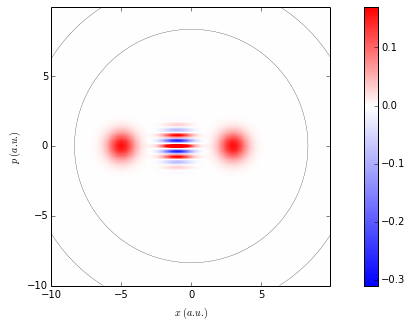

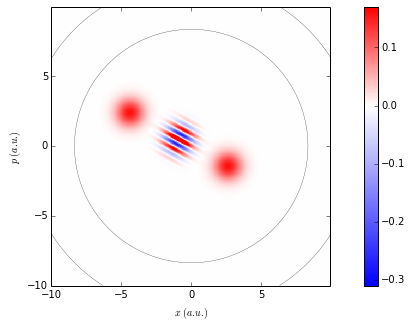

In [64]:
# --------------------  Plot final and initial wigner states ---------------------------------

W_supr_cohe_end = dat2[0]
W_supr_cohe_end /= np.sum(W_supr_cohe_end)*dX*dP

Plot_Compare_two_states( W_supr_cohe_init ,W_supr_cohe_end  )

In [65]:
# Data of Ehrenfest Theorems
    
Eh2 = data_Ehrenfest( dat2[1],dat2[2],dat2[3],dat2[4],dat2[5],dat2[6],dat2[7],dat2[8] ,dat2[9] ,dat2[10])

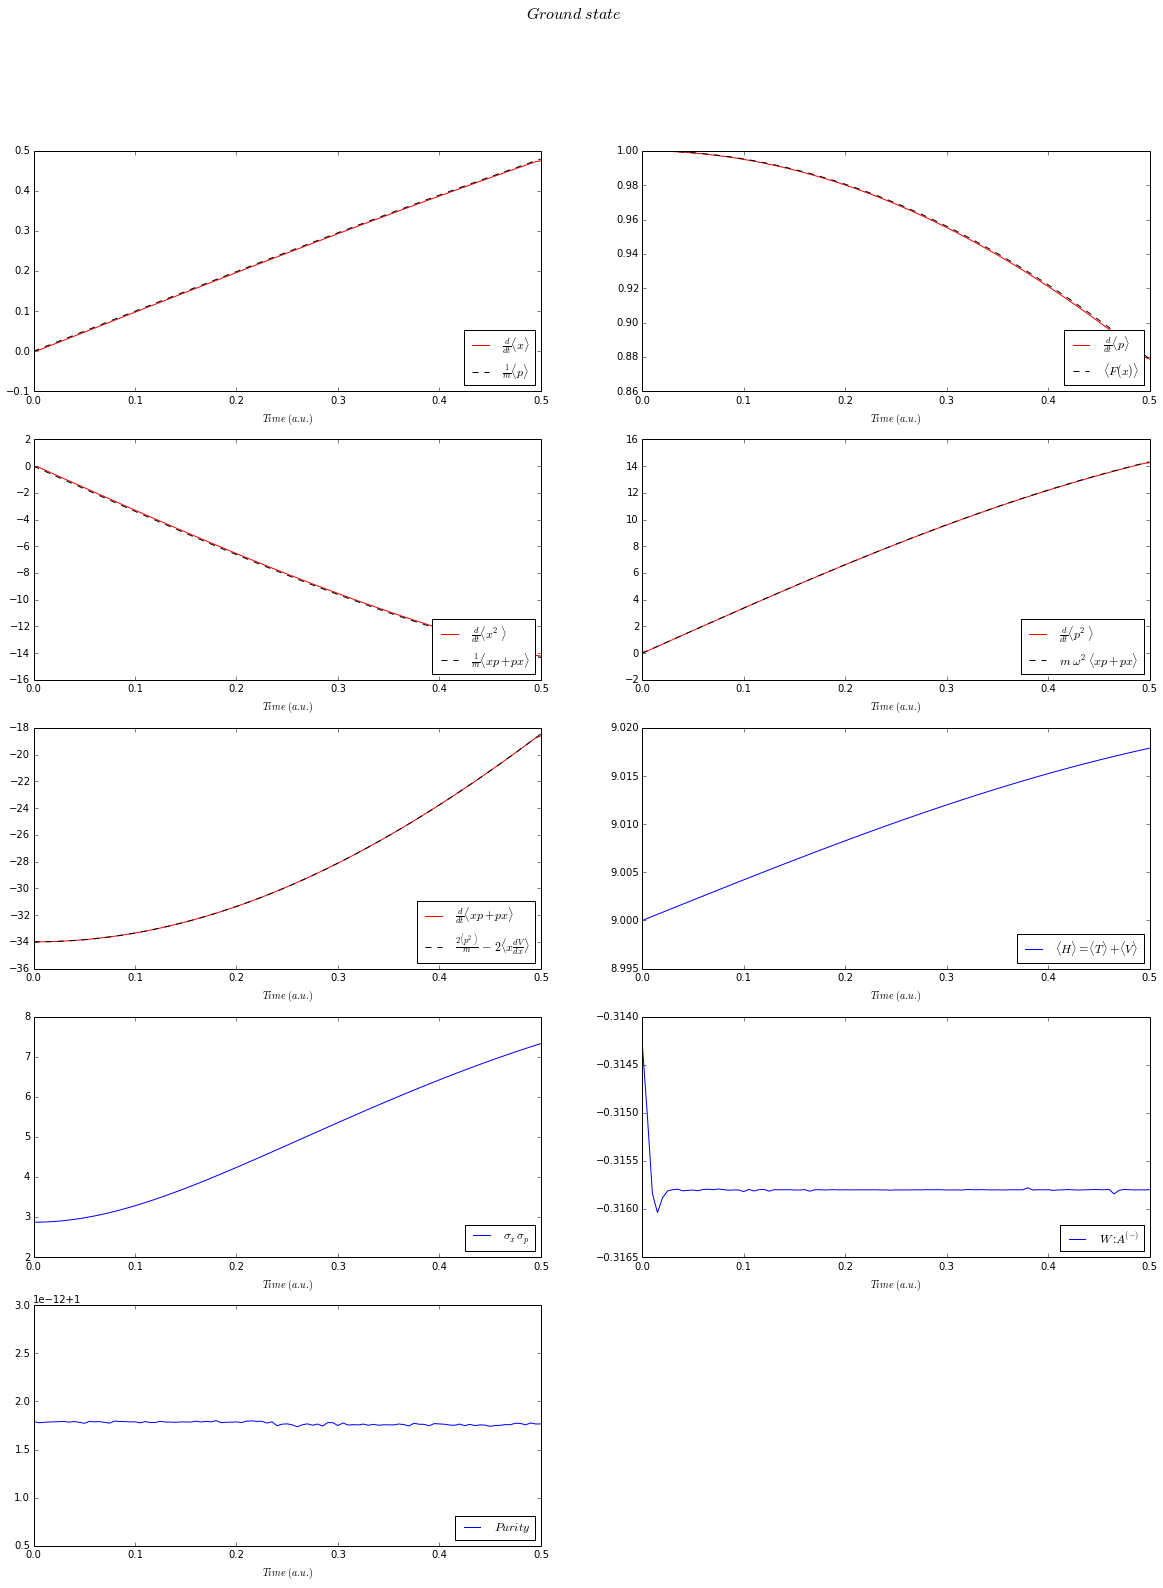

IMAGINARY AND REAL FEATURES:

d< X >/dt      Max imaginary : -7.85511323669e-15  Min imaginary : -3.19023284093e-14
d< X >/dt      Max real : 0.475033589482  Min real : -6.72795152923e-12

< P >/m        Max imaginary : -6.69604856421e-17  Min imaginary : -1.42717644609e-14
< P >/m        Max real : 0.479427493891  Min real 6.70214819515e-18

d< P >/dt      Max imaginary : -8.89308873038e-15          Min imaginary : -4.51865153004e-14
d< P >/dt      Max real : 0.999999999996                             Min real : 0.878780880917

< F >          Max imaginary : 1.00848488289e-14                        Min imaginary : -5.19054224285e-34
< F >          Max real : 0.999999999997                   Min real 0.878780880921

d< X2 >/dt      Max imaginary : 4.05685641623e-14                   Min imaginary : -1.03783598064e-13
d< X2 >/dt      Max real : 0.00249999091935               Min real : -14.2111291771

< XP + PX >/m          Max imaginary : 7.32381551826e-15      Min imaginary : -1.69300

In [66]:
# Plot Ehrenfest's Theorems

Plot_Ehrenfest( "$ Ground \\  state $" ,Eh2[0],Eh2[1],Eh2[2],Eh2[3],Eh2[4],Eh2[5], Eh2[6] ,Eh2[7], Eh2[8],Eh2[9],Eh2[10], Eh2[11],Eh2[12],Eh2[13] )  

# 7. Excited states of H. O.

In [80]:
#-------------------------- 15th Excited state of H. O. -------------------------------------

W_3_exc_init = W_excited_HO_semi_analytical( 1 )

#---------------------------- Normalization-------------------------------------------------------

W_3_exc_init  /= np.sum(W_3_exc_init )*dX*dP

print "The renormalization norm is:" , np.sum(W_3_exc_init )*dX*dP

The renormalization norm is: (1-5.54833333588e-34j)


In [81]:
# data of Wigner propagator  and usefull variables

dat3 = WignerPropagator( W_3_exc_init )

Computation time to compute propagation =  7.91423106194  seconds


Differences beetween inital and final  Wigner states :
Real Max:  0.000461516665548
Real Min:  1.9085706178e-22


Features of inital wigner state
max imaginary =  3.76804472461e-17
min real =  -0.318309886184  max real =  0.142048437754
normalization =  1.0

Features of final wigner state
max imaginary =  0.0
min real =  -0.318309886184  max real =  0.142049071657
normalization =  1.0


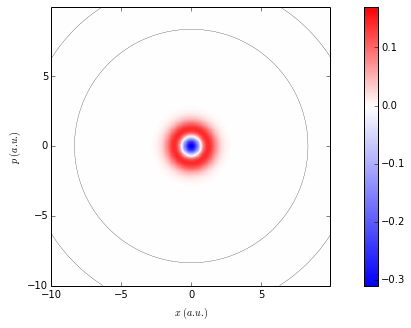

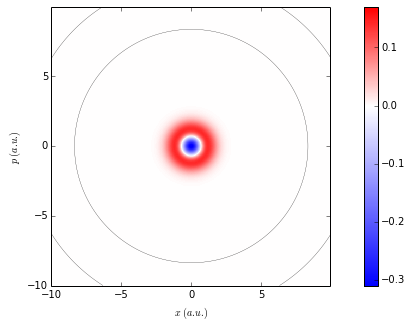

In [82]:
# --------------------  Plot final and initial wigner states ---------------------------------

W_3_exc_end  = dat3[0]
W_3_exc_end  /= np.sum(W_3_exc_end )*dX*dP

Plot_Compare_two_states( W_3_exc_init , W_3_exc_end  )

In [70]:
# Data of Ehrenfest Theorems
    
Eh3 = data_Ehrenfest( dat3[1],dat3[2],dat3[3],dat3[4],dat3[5],dat3[6],dat3[7],dat3[8] ,dat3[9] ,dat3[10])

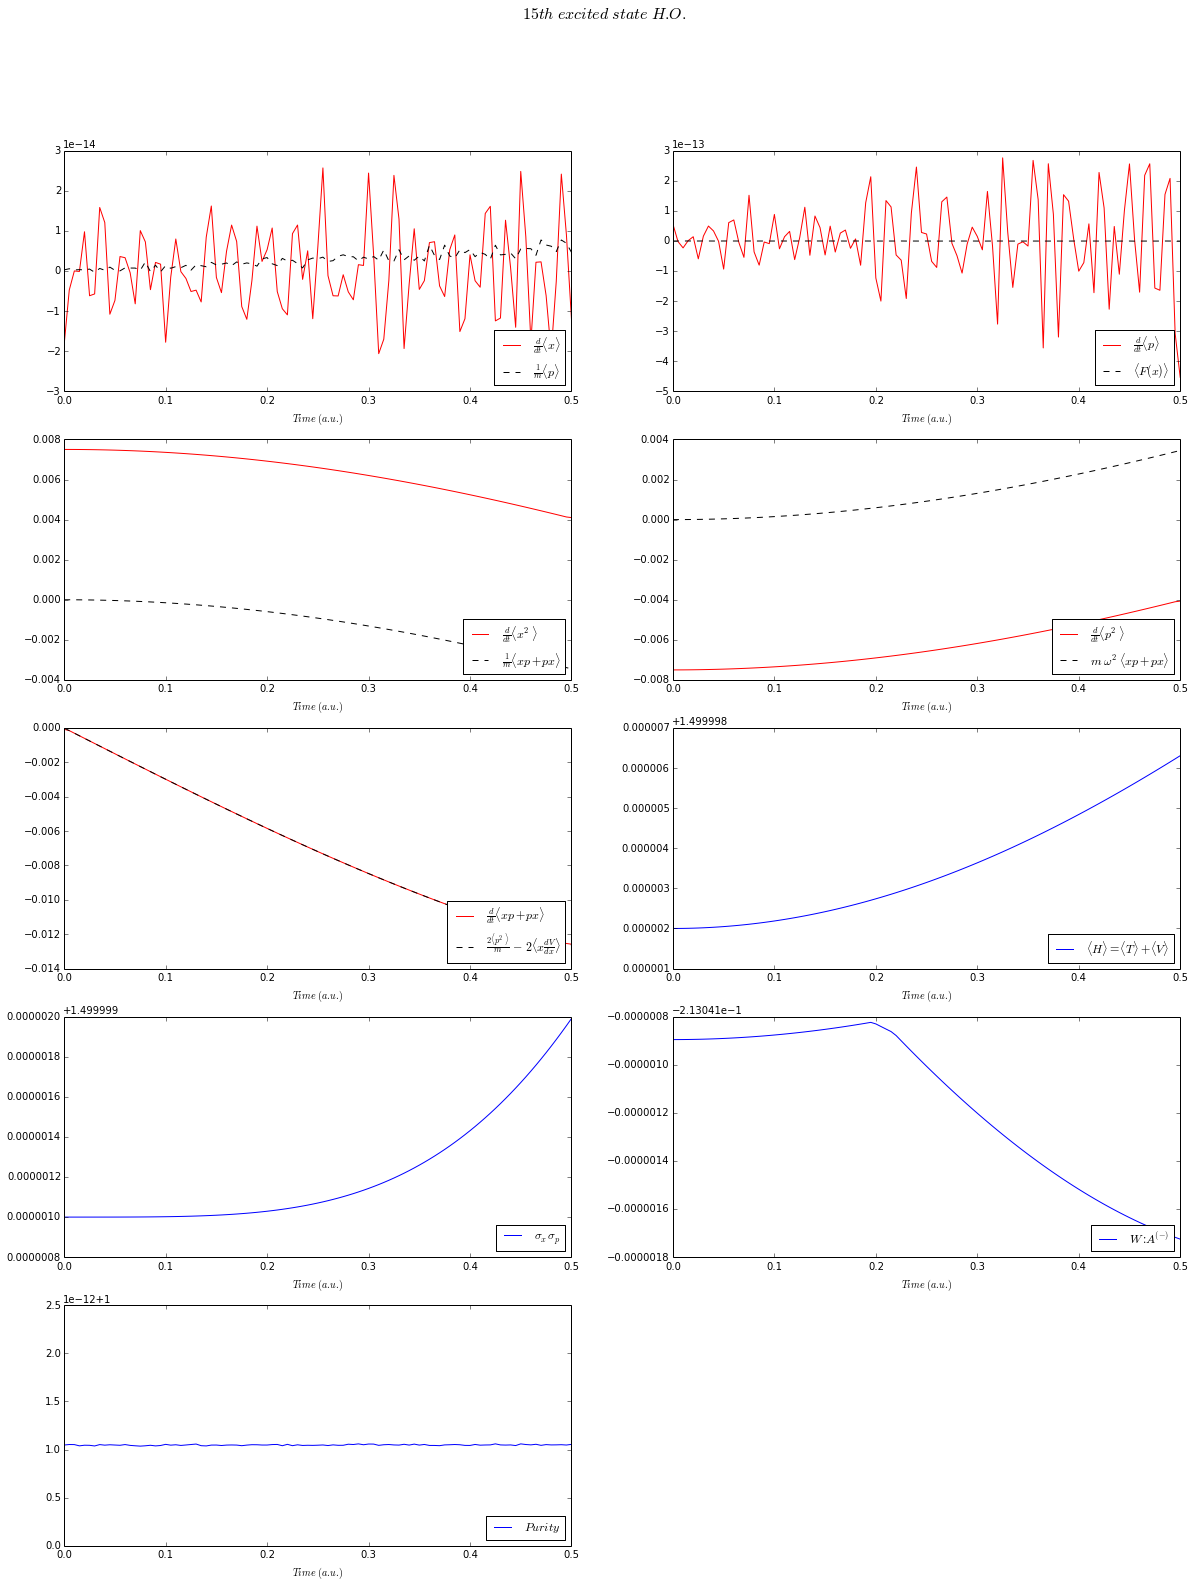

IMAGINARY AND REAL FEATURES:

d< X >/dt      Max imaginary : -1.56804228161e-14  Min imaginary : -5.54534536556e-14
d< X >/dt      Max real : 2.57286257728e-14  Min real : -2.06032823486e-14

< P >/m        Max imaginary : -1.4341337216e-16  Min imaginary : -1.3299047441e-14
< P >/m        Max real : 7.76440692035e-15  Min real -3.01821661908e-16

d< P >/dt      Max imaginary : -6.93243348226e-16          Min imaginary : -5.5868323826e-14
d< P >/dt      Max real : 2.76535346153e-13                             Min real : -4.53454853148e-13

< F >          Max imaginary : 1.63497165118e-14                        Min imaginary : -2.23343926656e-34
< F >          Max real : 9.08389896371e-17                   Min real -4.18661916048e-16

d< X2 >/dt      Max imaginary : 6.03389935442e-15                   Min imaginary : -2.24443534758e-14
d< X2 >/dt      Max real : 0.00749999999852               Min real : 0.00409949194045

< XP + PX >/m          Max imaginary : 5.60074351431e-16      Min 

In [71]:
# Plot Ehrenfest's Theorems

Plot_Ehrenfest( "$ 15th \\ excited \\ state \\ H.O. $" ,Eh3[0],Eh3[1],Eh3[2],Eh3[3],Eh3[4],Eh3[5], Eh3[6] ,Eh3[7], Eh3[8],Eh3[9],Eh3[10], Eh3[11],Eh3[12],Eh3[13] )  